In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [2]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [3]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [4]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

/home/daniel/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

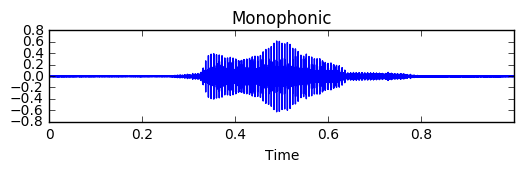

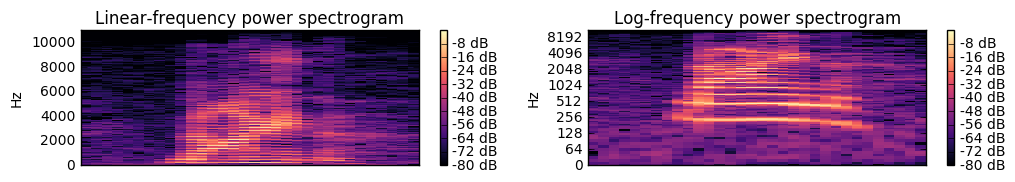

In [6]:
plt.show()

In [2]:
DATA_PATH = "/home/daniel/data/"

In [117]:
hop_length = 320

## LOAD DATA

In [118]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [119]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

## CONVERT WAV TO MFCC

In [120]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3] #downsampling, 
    mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=26,n_fft=int(16000*0.04))

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

## SAVE DATA TO FILE NPY

In [121]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

## SET PROPORTION FOR DATA TRAINING AND DATA TESTING

In [122]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

## SET HYPER PARAMETER FOR MODEL

In [123]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 26
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [124]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [39]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [40]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 12s 446us/step - loss: 4.3644 - acc: 0.2632 - val_loss: 1.8863 - val_acc: 0.4212
Epoch 2/25
27200/27200 [==============================] - 11s 406us/step - loss: 1.5056 - acc: 0.5283 - val_loss: 1.3990 - val_acc: 0.5593
Epoch 3/25
27200/27200 [==============================] - 10s 367us/step - loss: 1.2016 - acc: 0.6225 - val_loss: 1.2545 - val_acc: 0.6106
Epoch 4/25
27200/27200 [==============================] - 10s 372us/step - loss: 1.0327 - acc: 0.6706 - val_loss: 1.2577 - val_acc: 0.6082
Epoch 5/25
27200/27200 [==============================] - 9s 336us/step - loss: 0.9095 - acc: 0.7080 - val_loss: 1.2508 - val_acc: 0.6262
Epoch 6/25
27200/27200 [==============================] - 10s 358us/step - loss: 0.7961 - acc: 0.7441 - val_loss: 1.2702 - val_acc: 0.6282
Epoch 7/25
27200/27200 [==============================] - 10s 364us/step - loss: 0.7226 - acc: 0.7667 - val_loss: 1.30

## INITIALIZE MODEL SPNET

In [125]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [105]:
model13 = model_spnet()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 372us/step - loss: 2.7176 - acc: 0.1595 - val_loss: 2.1070 - val_acc: 0.3316
Epoch 2/25
27200/27200 [==============================] - 7s 269us/step - loss: 1.8545 - acc: 0.4107 - val_loss: 1.4648 - val_acc: 0.5321
Epoch 3/25
27200/27200 [==============================] - 8s 297us/step - loss: 1.4205 - acc: 0.5480 - val_loss: 1.4126 - val_acc: 0.5628
Epoch 4/25
27200/27200 [==============================] - 7s 268us/step - loss: 1.2413 - acc: 0.6052 - val_loss: 1.1959 - val_acc: 0.6225
Epoch 5/25
27200/27200 [==============================] - 7s 266us/step - loss: 1.1363 - acc: 0.6372 - val_loss: 1.1516 - val_acc: 0.6376
Epoch 6/25
27200/27200 [==============================] - 8s 288us/step - loss: 1.0620 - acc: 0.6614 - val_loss: 1.1535 - val_acc: 0.6465
Epoch 7/25
27200/27200 [==============================] - 7s 270us/step - loss: 1.0084 - acc: 0.6784 - val_loss: 1.0760 - 

In [42]:
model20 = model_spnet()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 12s 450us/step - loss: 2.6656 - acc: 0.1787 - val_loss: 2.0087 - val_acc: 0.3538
Epoch 2/25
27200/27200 [==============================] - 10s 385us/step - loss: 1.7350 - acc: 0.4456 - val_loss: 1.4906 - val_acc: 0.5307
Epoch 3/25
27200/27200 [==============================] - 10s 376us/step - loss: 1.3321 - acc: 0.5746 - val_loss: 1.3886 - val_acc: 0.5679
Epoch 4/25
27200/27200 [==============================] - 10s 379us/step - loss: 1.1605 - acc: 0.6296 - val_loss: 1.1022 - val_acc: 0.6515
Epoch 5/25
27200/27200 [==============================] - 11s 388us/step - loss: 1.0544 - acc: 0.6596 - val_loss: 1.3059 - val_acc: 0.6034
Epoch 6/25
27200/27200 [==============================] - 11s 414us/step - loss: 0.9649 - acc: 0.6911 - val_loss: 1.0669 - val_acc: 0.6763
Epoch 7/25
27200/27200 [==============================] - 12s 451us/step - loss: 0.9072 - acc: 0.7088 - val_loss: 1.1

In [126]:
model26 = model_spnet()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 17s 629us/step - loss: 2.6952 - acc: 0.1707 - val_loss: 2.2187 - val_acc: 0.2891
Epoch 2/25
27200/27200 [==============================] - 15s 552us/step - loss: 1.8792 - acc: 0.3963 - val_loss: 1.5349 - val_acc: 0.5109
Epoch 3/25
27200/27200 [==============================] - 14s 511us/step - loss: 1.4552 - acc: 0.5346 - val_loss: 1.3564 - val_acc: 0.5700
Epoch 4/25
27200/27200 [==============================] - 16s 575us/step - loss: 1.2306 - acc: 0.6070 - val_loss: 1.2419 - val_acc: 0.6057
Epoch 5/25
27200/27200 [==============================] - 15s 556us/step - loss: 1.0989 - acc: 0.6475 - val_loss: 1.2987 - val_acc: 0.6053
Epoch 6/25
27200/27200 [==============================] - 15s 552us/step - loss: 1.0116 - acc: 0.6755 - val_loss: 1.1504 - val_acc: 0.6381
Epoch 7/25
27200/27200 [==============================] - 17s 628us/step - loss: 0.9350 - acc: 0.6991 - val_loss: 1.1

In [127]:
def model_spnet2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(50, kernel_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [107]:
model13 = model_spnet2()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 6s 220us/step - loss: 3.5652 - acc: 0.1256 - val_loss: 2.5492 - val_acc: 0.1950
Epoch 2/25
27200/27200 [==============================] - 5s 178us/step - loss: 2.3620 - acc: 0.2580 - val_loss: 2.3369 - val_acc: 0.2703
Epoch 3/25
27200/27200 [==============================] - 5s 177us/step - loss: 2.0929 - acc: 0.3368 - val_loss: 2.0492 - val_acc: 0.3431
Epoch 4/25
27200/27200 [==============================] - 4s 164us/step - loss: 1.9359 - acc: 0.3884 - val_loss: 1.8892 - val_acc: 0.3957
Epoch 5/25
27200/27200 [==============================] - 5s 167us/step - loss: 1.8084 - acc: 0.4302 - val_loss: 1.7734 - val_acc: 0.4535
Epoch 6/25
27200/27200 [==============================] - 4s 164us/step - loss: 1.7223 - acc: 0.4529 - val_loss: 1.7399 - val_acc: 0.4507
Epoch 7/25
27200/27200 [==============================] - 4s 162us/step - loss: 1.6495 - acc: 0.4789 - val_loss: 1.7059 - v

In [50]:
model20 = model_spnet2()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 7s 268us/step - loss: 3.1245 - acc: 0.1551 - val_loss: 2.5254 - val_acc: 0.2174
Epoch 2/25
27200/27200 [==============================] - 7s 275us/step - loss: 2.2378 - acc: 0.2971 - val_loss: 2.0411 - val_acc: 0.3557
Epoch 3/25
27200/27200 [==============================] - 7s 241us/step - loss: 1.9402 - acc: 0.3906 - val_loss: 1.8831 - val_acc: 0.4076
Epoch 4/25
27200/27200 [==============================] - 7s 251us/step - loss: 1.7727 - acc: 0.4385 - val_loss: 1.7580 - val_acc: 0.4468
Epoch 5/25
27200/27200 [==============================] - 8s 277us/step - loss: 1.6530 - acc: 0.4783 - val_loss: 1.6866 - val_acc: 0.4799
Epoch 6/25
27200/27200 [==============================] - 7s 269us/step - loss: 1.5646 - acc: 0.5044 - val_loss: 1.6696 - val_acc: 0.4799
Epoch 7/25
27200/27200 [==============================] - 7s 251us/step - loss: 1.5027 - acc: 0.5239 - val_loss: 1.5459 - v

In [128]:
model26 = model_spnet2()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 381us/step - loss: 5.0979 - acc: 0.1324 - val_loss: 2.3994 - val_acc: 0.2472
Epoch 2/25
27200/27200 [==============================] - 10s 356us/step - loss: 2.2590 - acc: 0.2892 - val_loss: 2.1128 - val_acc: 0.3512
Epoch 3/25
27200/27200 [==============================] - 9s 323us/step - loss: 1.9438 - acc: 0.3841 - val_loss: 1.8886 - val_acc: 0.4044
Epoch 4/25
27200/27200 [==============================] - 10s 359us/step - loss: 1.7592 - acc: 0.4417 - val_loss: 1.7075 - val_acc: 0.4644
Epoch 5/25
27200/27200 [==============================] - 9s 336us/step - loss: 1.6254 - acc: 0.4815 - val_loss: 1.8426 - val_acc: 0.4221
Epoch 6/25
27200/27200 [==============================] - 8s 305us/step - loss: 1.5344 - acc: 0.5105 - val_loss: 1.6724 - val_acc: 0.4721
Epoch 7/25
27200/27200 [==============================] - 10s 360us/step - loss: 1.4588 - acc: 0.5337 - val_loss: 1.5453

In [129]:
def model_spnet3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(50, kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [109]:
model13 = model_spnet3()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 378us/step - loss: 3.4471 - acc: 0.1518 - val_loss: 2.4367 - val_acc: 0.2432
Epoch 2/25
27200/27200 [==============================] - 9s 317us/step - loss: 2.0816 - acc: 0.3537 - val_loss: 1.8132 - val_acc: 0.4450
Epoch 3/25
27200/27200 [==============================] - 9s 332us/step - loss: 1.6729 - acc: 0.4733 - val_loss: 1.6023 - val_acc: 0.5054
Epoch 4/25
27200/27200 [==============================] - 8s 295us/step - loss: 1.4561 - acc: 0.5397 - val_loss: 1.3728 - val_acc: 0.5747
Epoch 5/25
27200/27200 [==============================] - 9s 345us/step - loss: 1.3087 - acc: 0.5873 - val_loss: 1.4078 - val_acc: 0.5597
Epoch 6/25
27200/27200 [==============================] - 9s 317us/step - loss: 1.2145 - acc: 0.6181 - val_loss: 1.3519 - val_acc: 0.5896
Epoch 7/25
27200/27200 [==============================] - 9s 319us/step - loss: 1.1326 - acc: 0.6460 - val_loss: 1.2087 - 

In [57]:
model20 = model_spnet3()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 13s 475us/step - loss: 5.0593 - acc: 0.1354 - val_loss: 2.9061 - val_acc: 0.1594
Epoch 2/25
27200/27200 [==============================] - 13s 489us/step - loss: 2.1049 - acc: 0.3463 - val_loss: 1.9982 - val_acc: 0.3818
Epoch 3/25
27200/27200 [==============================] - 12s 458us/step - loss: 1.6582 - acc: 0.4836 - val_loss: 1.6924 - val_acc: 0.4751
Epoch 4/25
27200/27200 [==============================] - 10s 380us/step - loss: 1.4168 - acc: 0.5556 - val_loss: 1.5661 - val_acc: 0.5266
Epoch 5/25
27200/27200 [==============================] - 12s 435us/step - loss: 1.2696 - acc: 0.6004 - val_loss: 1.2874 - val_acc: 0.5959
Epoch 6/25
27200/27200 [==============================] - 14s 513us/step - loss: 1.1477 - acc: 0.6369 - val_loss: 1.3563 - val_acc: 0.5876
Epoch 7/25
27200/27200 [==============================] - 12s 448us/step - loss: 1.0726 - acc: 0.6586 - val_loss: 1.2

In [130]:
model26 = model_spnet3()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 570us/step - loss: 3.2705 - acc: 0.1818 - val_loss: 2.2533 - val_acc: 0.2903
Epoch 2/25
27200/27200 [==============================] - 13s 482us/step - loss: 1.9044 - acc: 0.4050 - val_loss: 1.9178 - val_acc: 0.4187
Epoch 3/25
27200/27200 [==============================] - 16s 576us/step - loss: 1.4904 - acc: 0.5324 - val_loss: 1.3716 - val_acc: 0.5690
Epoch 4/25
27200/27200 [==============================] - 16s 579us/step - loss: 1.2766 - acc: 0.5944 - val_loss: 1.3087 - val_acc: 0.5938
Epoch 5/25
27200/27200 [==============================] - 15s 560us/step - loss: 1.1372 - acc: 0.6397 - val_loss: 1.2398 - val_acc: 0.6099
Epoch 6/25
27200/27200 [==============================] - 14s 531us/step - loss: 1.0375 - acc: 0.6706 - val_loss: 1.1583 - val_acc: 0.6394
Epoch 7/25
27200/27200 [==============================] - 16s 582us/step - loss: 0.9617 - acc: 0.6932 - val_loss: 1.1

In [174]:
def model_spnet4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [175]:
model13 = model_spnet4()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 29s 1ms/step - loss: 3.0817 - acc: 0.2203 - val_loss: 1.8658 - val_acc: 0.4026
Epoch 2/25
27200/27200 [==============================] - 26s 957us/step - loss: 1.6357 - acc: 0.4861 - val_loss: 1.3673 - val_acc: 0.5688
Epoch 3/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.2470 - acc: 0.6025 - val_loss: 1.3321 - val_acc: 0.5881
Epoch 4/25
27200/27200 [==============================] - 27s 981us/step - loss: 1.0724 - acc: 0.6585 - val_loss: 1.0906 - val_acc: 0.6604
Epoch 5/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.9364 - acc: 0.7017 - val_loss: 1.0633 - val_acc: 0.6732
Epoch 6/25
27200/27200 [==============================] - 27s 998us/step - loss: 0.8468 - acc: 0.7292 - val_loss: 1.0264 - val_acc: 0.6872
Epoch 7/25
27200/27200 [==============================] - 27s 994us/step - loss: 0.7673 - acc: 0.7519 - val_loss: 1.0185 - 

In [66]:
model20 = model_spnet4()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 19s 710us/step - loss: 5.2378 - acc: 0.1738 - val_loss: 2.0903 - val_acc: 0.3341
Epoch 2/25
27200/27200 [==============================] - 19s 709us/step - loss: 1.6842 - acc: 0.4661 - val_loss: 1.3792 - val_acc: 0.5631
Epoch 3/25
27200/27200 [==============================] - 19s 687us/step - loss: 1.2857 - acc: 0.5936 - val_loss: 1.2577 - val_acc: 0.5966
Epoch 4/25
27200/27200 [==============================] - 20s 720us/step - loss: 1.0801 - acc: 0.6589 - val_loss: 1.0930 - val_acc: 0.6610
Epoch 5/25
27200/27200 [==============================] - 20s 737us/step - loss: 0.9574 - acc: 0.6950 - val_loss: 1.2019 - val_acc: 0.6366
Epoch 6/25
27200/27200 [==============================] - 20s 742us/step - loss: 0.8744 - acc: 0.7193 - val_loss: 1.0928 - val_acc: 0.6557
Epoch 7/25
27200/27200 [==============================] - 19s 705us/step - loss: 0.7932 - acc: 0.7438 - val_loss: 1.0

In [137]:
model26 = model_spnet4()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 29s 1ms/step - loss: 6.2586 - acc: 0.1556 - val_loss: 2.0911 - val_acc: 0.3350
Epoch 2/25
27200/27200 [==============================] - 27s 986us/step - loss: 1.7286 - acc: 0.4544 - val_loss: 1.4135 - val_acc: 0.5624
Epoch 3/25
27200/27200 [==============================] - 25s 926us/step - loss: 1.2750 - acc: 0.5956 - val_loss: 1.2007 - val_acc: 0.6194
Epoch 4/25
27200/27200 [==============================] - 25s 935us/step - loss: 1.0691 - acc: 0.6625 - val_loss: 1.1038 - val_acc: 0.6578
Epoch 5/25
27200/27200 [==============================] - 25s 935us/step - loss: 0.9404 - acc: 0.6976 - val_loss: 1.0260 - val_acc: 0.6746
Epoch 6/25
27200/27200 [==============================] - 26s 944us/step - loss: 0.8445 - acc: 0.7275 - val_loss: 1.1364 - val_acc: 0.6501
Epoch 7/25
27200/27200 [==============================] - 26s 964us/step - loss: 0.7695 - acc: 0.7492 - val_loss: 0.970

In [133]:
def model_spnet6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6), strides=1))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [113]:
model13 = model_spnet6()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 17s 618us/step - loss: 2.6729 - acc: 0.2125 - val_loss: 2.1845 - val_acc: 0.3174
Epoch 2/25
27200/27200 [==============================] - 17s 622us/step - loss: 1.6390 - acc: 0.4791 - val_loss: 1.4190 - val_acc: 0.5522
Epoch 3/25
27200/27200 [==============================] - 18s 658us/step - loss: 1.3094 - acc: 0.5846 - val_loss: 1.1764 - val_acc: 0.6306
Epoch 4/25
27200/27200 [==============================] - 19s 685us/step - loss: 1.1274 - acc: 0.6417 - val_loss: 1.1712 - val_acc: 0.6387
Epoch 5/25
27200/27200 [==============================] - 19s 700us/step - loss: 1.0246 - acc: 0.6760 - val_loss: 1.0804 - val_acc: 0.6679
Epoch 6/25
27200/27200 [==============================] - 18s 665us/step - loss: 0.9369 - acc: 0.7030 - val_loss: 1.1451 - val_acc: 0.6538
Epoch 7/25
27200/27200 [==============================] - 16s 594us/step - loss: 0.8761 - acc: 0.7211 - val_loss: 1.0

In [98]:
model20 = model_spnet6()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 21s 758us/step - loss: 2.9676 - acc: 0.1942 - val_loss: 1.9554 - val_acc: 0.3696
Epoch 2/25
27200/27200 [==============================] - 22s 810us/step - loss: 1.6858 - acc: 0.4659 - val_loss: 1.4365 - val_acc: 0.5465
Epoch 3/25
27200/27200 [==============================] - 21s 777us/step - loss: 1.2999 - acc: 0.5860 - val_loss: 1.2024 - val_acc: 0.6147
Epoch 4/25
27200/27200 [==============================] - 20s 752us/step - loss: 1.1114 - acc: 0.6450 - val_loss: 1.1467 - val_acc: 0.6428
Epoch 5/25
27200/27200 [==============================] - 22s 827us/step - loss: 0.9886 - acc: 0.6845 - val_loss: 1.0908 - val_acc: 0.6663
Epoch 6/25
27200/27200 [==============================] - 24s 868us/step - loss: 0.9080 - acc: 0.7099 - val_loss: 1.1539 - val_acc: 0.6488
Epoch 7/25
27200/27200 [==============================] - 21s 769us/step - loss: 0.8166 - acc: 0.7382 - val_loss: 1.0

In [134]:
model26 = model_spnet6()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 30s 1ms/step - loss: 3.5614 - acc: 0.1514 - val_loss: 2.0674 - val_acc: 0.3212
Epoch 2/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.8293 - acc: 0.4146 - val_loss: 1.4529 - val_acc: 0.5313
Epoch 3/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.3534 - acc: 0.5678 - val_loss: 1.2423 - val_acc: 0.6113
Epoch 4/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.1318 - acc: 0.6392 - val_loss: 1.3178 - val_acc: 0.5969
Epoch 5/25
27200/27200 [==============================] - 28s 1ms/step - loss: 1.0050 - acc: 0.6775 - val_loss: 1.2494 - val_acc: 0.6194
Epoch 6/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.9126 - acc: 0.7071 - val_loss: 1.0721 - val_acc: 0.6697
Epoch 7/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.8297 - acc: 0.7336 - val_loss: 0.9632 - val_acc:

In [138]:
spnet = {}
lenet = {}
spnet_k2 = {}
spnet_k3 = {}
spnet_k4 = {}
spnet_k6 = {}

In [139]:
spnet[1] = 0.1787; spnet[5] = 0.6596; spnet[10] = 0.7541; spnet[15] = 0.7986; spnet[20] = 0.8318; spnet[25] = 0.8607; 

In [140]:
lenet[1] = 0.2547; lenet[5] = 0.6647; lenet[10] = 0.7732; lenet[15] = 0.8531; lenet[20] = 0.9156; lenet[25] = 0.9515; 

In [141]:
spnet_k2[1] = 0.1551; spnet_k2[5] = 0.4783; spnet_k2[10] = 0.5693; spnet_k2[15] = 0.6156; spnet_k2[20] = 0.6479; spnet_k2[25] = 0.6803; 

In [142]:
spnet_k3[1] = 0.1354; spnet_k3[5] = 0.6004; spnet_k3[10] = 0.7121; spnet_k3[15] = 0.7724; spnet_k3[20] = 0.8192; spnet_k3[25] = 0.8536; 

In [143]:
spnet_k4[1] = 0.1738; spnet_k4[5] = 0.6950; spnet_k4[10] = 0.7905; spnet_k4[15] = 0.8493; spnet_k4[20] = 0.8928; spnet_k4[25] = 0.9222; 

In [144]:
spnet_k6[1] = 0.1942; spnet_k6[5] = 0.6845; spnet_k6[10] = 0.7812; spnet_k6[15] = 0.8385; spnet_k6[20] = 0.8787; spnet_k6[25] = 0.9095; 

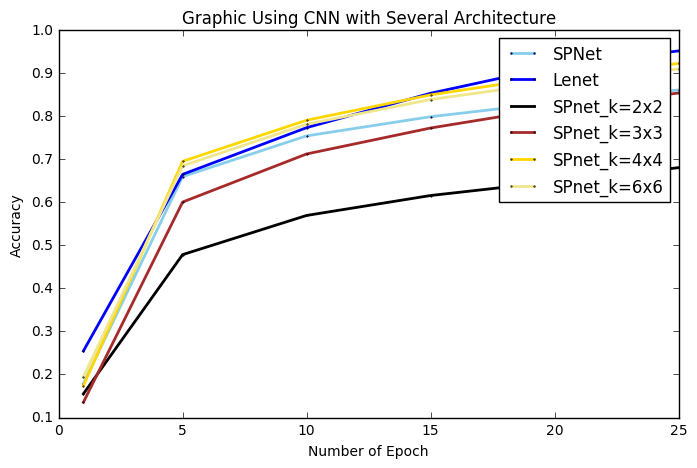

In [145]:
# Data
df=pd.DataFrame({'x': spnet.keys(), 'SPNet': spnet.values(), 'Lenet': lenet.values(), 'SPnet_k=2x2':spnet_k2.values(), 'SPnet_k=3x3':spnet_k3.values(), 'SPnet_k=4x4':spnet_k4.values(), 'SPnet_k=6x6':spnet_k6.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'SPnet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'SPnet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'SPnet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'SPnet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using CNN with Several Architecture')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [146]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),spnet_k2.values(),spnet_k3.values(),spnet_k4.values(),spnet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc20_val = pd.DataFrame([0.7056,0.6553,0.5649, 0.6784,0.7194,0.7204])
tabel_acc20_val = tabel_acc20_val.T
tabel_acc20_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR KOEFISIEN 20

In [147]:
tabel_acc20

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1787,0.2547,0.1551,0.1354,0.1738,0.1942
1,5.0,0.6596,0.6647,0.4783,0.6004,0.6950,0.6845
2,10.0,0.7541,0.7732,0.5693,0.7121,0.7905,0.7812
3,15.0,0.7986,0.8531,0.6156,0.7724,0.8493,0.8385
4,20.0,0.8318,0.9156,0.6479,0.8192,0.8928,0.8787
5,25.0,0.8607,0.9515,0.6803,0.8536,0.9222,0.9095


## VALIDATION ACCURATION FOR COEFFICIENT 20

In [148]:
tabel_acc20_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7056,0.6553,0.5649,0.6784,0.7194,0.7204


In [176]:
spnet13 = {}
lenet13 = {}
spnet13_k2 = {}
spnet13_k3 = {}
spnet13_k4 = {}
spnet13_k6 = {}

In [177]:
spnet13[1] = 0.1595; spnet13[5] = 0.6372; spnet13[10] = 0.7174; spnet13[15] = 0.7582; spnet13[20] = 0.7828; spnet13[25] = 0.8031; 

In [178]:
lenet13[1] = 0.2245; lenet13[5] = 0.6476; lenet13[10] = 0.7343; lenet13[15] = 0.7928; lenet13[20] = 0.8426; lenet13[25] = 0.8827; 

In [179]:
spnet13_k2[1] = 0.1256; spnet13_k2[5] = 0.4302; spnet13_k2[10] = 0.5223; spnet13_k2[15] = 0.5651; spnet13_k2[20] = 0.5998; spnet13_k2[25] = 0.6269; 

In [180]:
spnet13_k3[1] = 0.1518; spnet13_k3[5] = 0.5873; spnet13_k3[10] = 0.6916; spnet13_k3[15] = 0.7483; spnet13_k3[20] = 0.7824; spnet13_k3[25] = 0.8215; 

In [181]:
spnet13_k4[1] = 0.2203; spnet13_k4[5] = 0.7017; spnet13_k4[10] = 0.8057; spnet13_k4[15] = 0.8676; spnet13_k4[20] = 0.9068; spnet13_k4[25] = 0.9319; 

In [182]:
spnet13_k6[1] = 0.2125; spnet13_k6[5] = 0.6760; spnet13_k6[10] = 0.7656; spnet13_k6[15] = 0.8102; spnet13_k6[20] = 0.8511; spnet13_k6[25] = 0.8734; 

In [183]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),spnet13_k2.values(),spnet13_k3.values(),spnet13_k4.values(),spnet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc13_val = pd.DataFrame([0.7093,0.6559,0.5607,0.6699,0.7218,0.7296])
tabel_acc13_val = tabel_acc13_val.T
tabel_acc13_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 13

In [184]:
tabel_acc13

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1595,0.2245,0.1256,0.1518,0.2203,0.2125
1,5.0,0.6372,0.6476,0.4302,0.5873,0.7017,0.6760
2,10.0,0.7174,0.7343,0.5223,0.6916,0.8057,0.7656
3,15.0,0.7582,0.7928,0.5651,0.7483,0.8676,0.8102
4,20.0,0.7828,0.8426,0.5998,0.7824,0.9068,0.8511
5,25.0,0.8031,0.8827,0.6269,0.8215,0.9319,0.8734


## VALIDATION ACCURATION FOR COEFFICIENT 13

In [185]:
tabel_acc13_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7093,0.6559,0.5607,0.6699,0.7218,0.7296


In [159]:
spnet26 = {}
lenet26 = {}
spnet26_k2 = {}
spnet26_k3 = {}
spnet26_k4 = {}
spnet26_k6 = {}

In [160]:
spnet26[1] = 0.1707; spnet26[5] = 0.6475; spnet26[10] = 0.7446; spnet26[15] = 0.7990; spnet26[20] = 0.8366; spnet26[25] = 0.8676; 

In [161]:
lenet26[1] = 0.0533; lenet26[5] = 0.6786; lenet26[10] = 0.7873; lenet26[15] = 0.8791; lenet26[20] = 0.9398; lenet26[25] = 0.9709;

In [162]:
spnet26_k2[1] = 0.1324; spnet26_k2[5] = 0.4815; spnet26_k2[10] = 0.5792; spnet26_k2[15] = 0.6421; spnet26_k2[20] = 0.6821; spnet26_k2[25] = 0.7170; 

In [163]:
spnet26_k3[1] = 0.1818; spnet26_k3[5] = 0.6397; spnet26_k3[10] = 0.7464; spnet26_k3[15] = 0.8063; spnet26_k3[20] = 0.8545; spnet26_k3[25] = 0.8893; 

In [164]:
spnet26_k4[1] = 0.1556; spnet26_k4[5] = 0.6976; spnet26_k4[10] = 0.8033; spnet26_k4[15] = 0.8673; spnet26_k4[20] = 0.9060; spnet26_k4[25] = 0.9322; 

In [165]:
spnet26_k6[1] = 0.1514; spnet26_k6[5] = 0.6775; spnet26_k6[10] = 0.7850; spnet26_k6[15] = 0.8429; spnet26_k6[20] = 0.8844; spnet26_k6[25] = 0.9161; 

In [166]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),spnet26_k2.values(),spnet26_k3.values(),spnet26_k4.values(),spnet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']
tabel_acc26_val = pd.DataFrame([0.7082,0.6610,0.5635,0.6856,0.7249,0.7276])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 26

In [167]:
tabel_acc26

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.1707,0.0533,0.1324,0.1818,0.1556,0.1514
1,5.0,0.6475,0.6786,0.4815,0.6397,0.6976,0.6775
2,10.0,0.7446,0.7873,0.5792,0.7464,0.8033,0.7850
3,15.0,0.7990,0.8791,0.6421,0.8063,0.8673,0.8429
4,20.0,0.8366,0.9398,0.6821,0.8545,0.9060,0.8844
5,25.0,0.8676,0.9709,0.7170,0.8893,0.9322,0.9161


## VALIDATION ACCURATION FOR COEFFICIENT 26

In [168]:
tabel_acc26_val

,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,0.7082,0.661,0.5635,0.6856,0.7249,0.7276


In [169]:
sp_graph = {}
lenet_graph = {}
spnet2_graph = {}
spnet3_graph = {}
spnet4_graph = {}
spnet6_graph = {}
sp_graph[13] = 0.7093; lenet_graph[13] = 0.6559; spnet2_graph[13] = 0.5607; spnet3_graph[13] = 0.6699; spnet4_graph[13] = 0.7312; spnet6_graph[13] = 0.7296;
sp_graph[20] = 0.7056; lenet_graph[20] = 0.6553; spnet2_graph[20] = 0.5649; spnet3_graph[20] = 0.6784; spnet4_graph[20] = 0.7194; spnet6_graph[20] = 0.7204;
sp_graph[26] = 0.7082; lenet_graph[26] = 0.661; spnet2_graph[26] = 0.5635; spnet3_graph[26] = 0.6856; spnet4_graph[26] = 0.7249; spnet6_graph[26] = 0.7276;

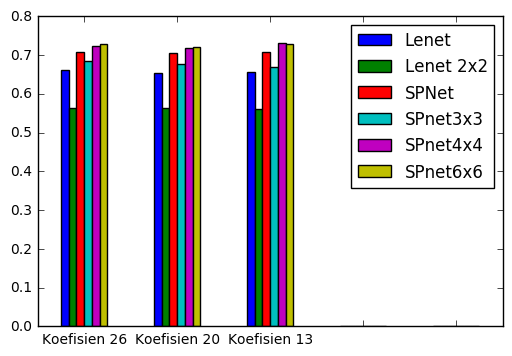

In [170]:
sp = [sp_graph[26],sp_graph[20],sp_graph[13],0,0]
le = [lenet_graph[26],lenet_graph[20],lenet_graph[13],0,0]
sp2 = [spnet2_graph[26],spnet2_graph[20],spnet2_graph[13],0,0]
sp3 = [spnet3_graph[26],spnet3_graph[20],spnet3_graph[13],0,0]
sp4 = [spnet4_graph[26],spnet4_graph[20],spnet4_graph[13],0,0]
sp6 = [spnet6_graph[26],spnet6_graph[20],spnet6_graph[13],0,0]
index = ["Koefisien 26",'Koefisien 20','Koefisien 13','','']
df = pd.DataFrame({'SPNet': sp,'Lenet': le,'Lenet 2x2': sp2,'SPnet3x3': sp3,'SPnet4x4': sp4,'SPnet6x6': sp6}, index=index)
ax = df.plot.bar(rot=0)
plt.show()

In [187]:
tp = {}
fp = {}
fn = {}

In [188]:
for i in labels:
    tp[i] = 0
    fp[i] = 0
    fn[i] = 0

In [189]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model26.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1
        tp[real]+=1
    else:
        fn[prediction]+=1
        fp[real]+=1

In [192]:
precision = {}
recall = {}
f1 = {}
accurationn = {}
error_rate = {}
for i in labels:
    precision[i] = 0
    recall[i] = 0
    f1[i] = 0
    error_rate[i] = 0

In [193]:
from __future__ import division
for i in labels:
    precision[i] = tp[i]/(tp[i]+fp[i])
    recall[i] = tp[i]/(tp[i]+fn[i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    error_rate[i] = 1-precision[i]

In [194]:
tabel_acc26_val = pd.DataFrame([precision.keys(),precision.values(),recall.values(),f1.values(),error_rate.values()])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['Label', 'Precision / Accuration', 'Recall', 'F - Measure','Error Rate']

## Confusion Matrix

In [195]:
tabel_acc26_val

,Label,Precision / Accuration,Recall,F - Measure,Error Rate
0,sheila,0.79375,0.731988,0.761619,0.20625
1,seven,0.705521,0.59126,0.643357,0.294479
2,right,0.584098,0.84141,0.689531,0.415902
3,three,0.67341,0.774086,0.720247,0.32659
4,no,0.643059,0.656069,0.649499,0.356941
5,marvin,0.806548,0.754875,0.779856,0.193452
6,wow,0.807365,0.833333,0.820144,0.192635
7,six,0.664706,0.833948,0.739771,0.335294
8,stop,0.635389,0.769481,0.696035,0.364611
9,up,0.696697,0.640884,0.667626,0.303303


## EXAMPLE PREDICTION OF VOICE 

In [196]:
print(predict('/home/daniel/data/zero/1c1060b1_nohash_1.wav', model=model_k4))

NameError: name 'model_k4' is not defined